In [0]:
from keras.datasets import fashion_mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU

import matplotlib.pyplot as plt
import sys
import numpy as np

Using TensorFlow backend.


In [0]:
class GAN():
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)


    def build_generator(self):

        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        
        model.add(Dense(2048))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Flatten(input_shape=self.img_shape))
        
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        (X_train, _), (_, _) = fashion_mnist.load_data()

        # Rescale -1 to 1
        X_train = X_train / 127.5 - 1.
        X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Generate a batch of new images
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Train the generator (to have the discriminator label samples as valid)
            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        #fig.savefig("images/%d.png" % epoch)
        plt.show()
        plt.close()




Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 256)           

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.634425, acc.: 46.88%] [G loss: 0.464400]


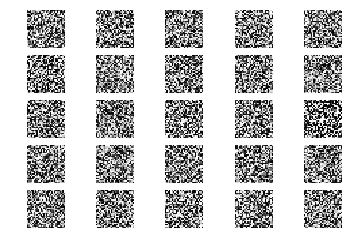

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1 [D loss: 0.696575, acc.: 50.00%] [G loss: 0.599251]
2 [D loss: 0.461799, acc.: 59.38%] [G loss: 0.907380]
3 [D loss: 0.262004, acc.: 98.44%] [G loss: 1.228188]
4 [D loss: 0.201913, acc.: 100.00%] [G loss: 1.490625]
5 [D loss: 0.165981, acc.: 98.44%] [G loss: 1.730204]
6 [D loss: 0.136478, acc.: 100.00%] [G loss: 1.998735]
7 [D loss: 0.115435, acc.: 100.00%] [G loss: 2.212980]
8 [D loss: 0.105357, acc.: 98.44%] [G loss: 2.414243]
9 [D loss: 0.092096, acc.: 98.44%] [G loss: 2.512574]
10 [D loss: 0.090382, acc.: 100.00%] [G loss: 2.697537]
11 [D loss: 0.048668, acc.: 100.00%] [G loss: 2.901622]
12 [D loss: 0.046569, acc.: 100.00%] [G loss: 3.050872]
13 [D loss: 0.038322, acc.: 100.00%] [G loss: 3.198756]
14 [D loss: 0.031671, acc.: 100.00%] [G loss: 3.308146]
15 [D loss: 0.035810, acc.: 100.00%] [G loss: 3.494271]
16 [D loss: 0.032230, acc.: 100.00%] [G loss: 3.763985]
17 [D loss: 0.038393, acc.: 98.44%] [G loss: 3.675381]
18 [D loss: 0.030897, acc.: 100.00%] [G loss: 3.521588]
19 [D lo

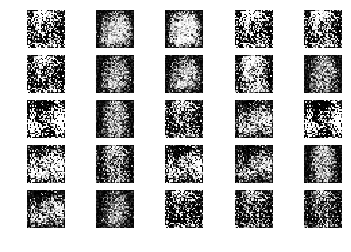

201 [D loss: 0.180033, acc.: 95.31%] [G loss: 4.326070]
202 [D loss: 0.154304, acc.: 98.44%] [G loss: 4.330094]
203 [D loss: 0.542388, acc.: 73.44%] [G loss: 5.531690]
204 [D loss: 0.392429, acc.: 85.94%] [G loss: 4.590273]
205 [D loss: 0.179550, acc.: 98.44%] [G loss: 4.979120]
206 [D loss: 0.372470, acc.: 84.38%] [G loss: 4.387599]
207 [D loss: 0.431899, acc.: 82.81%] [G loss: 4.652900]
208 [D loss: 0.467933, acc.: 76.56%] [G loss: 6.350351]
209 [D loss: 0.241021, acc.: 90.62%] [G loss: 4.927692]
210 [D loss: 0.319442, acc.: 89.06%] [G loss: 4.394476]
211 [D loss: 0.223932, acc.: 90.62%] [G loss: 5.149695]
212 [D loss: 0.269285, acc.: 89.06%] [G loss: 4.878782]
213 [D loss: 0.319958, acc.: 85.94%] [G loss: 4.789403]
214 [D loss: 0.429905, acc.: 78.12%] [G loss: 5.663352]
215 [D loss: 0.333550, acc.: 84.38%] [G loss: 5.177245]
216 [D loss: 0.269713, acc.: 89.06%] [G loss: 5.107801]
217 [D loss: 0.592481, acc.: 67.19%] [G loss: 4.335017]
218 [D loss: 0.149130, acc.: 98.44%] [G loss: 4.

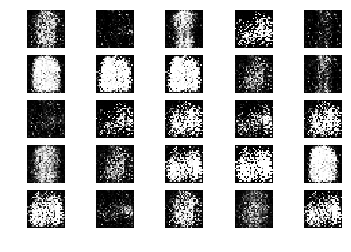

401 [D loss: 0.473712, acc.: 78.12%] [G loss: 2.555304]
402 [D loss: 0.629472, acc.: 70.31%] [G loss: 2.544713]
403 [D loss: 0.344815, acc.: 81.25%] [G loss: 3.422691]
404 [D loss: 0.473550, acc.: 81.25%] [G loss: 2.528168]
405 [D loss: 0.543220, acc.: 67.19%] [G loss: 3.209223]
406 [D loss: 0.398821, acc.: 82.81%] [G loss: 2.819940]
407 [D loss: 0.572222, acc.: 67.19%] [G loss: 2.724094]
408 [D loss: 0.527216, acc.: 75.00%] [G loss: 3.280605]
409 [D loss: 0.276316, acc.: 92.19%] [G loss: 3.017095]
410 [D loss: 0.750034, acc.: 57.81%] [G loss: 2.031778]
411 [D loss: 0.483245, acc.: 73.44%] [G loss: 2.713088]
412 [D loss: 0.464990, acc.: 82.81%] [G loss: 3.385940]
413 [D loss: 0.493960, acc.: 84.38%] [G loss: 2.543046]
414 [D loss: 0.429086, acc.: 81.25%] [G loss: 3.093657]
415 [D loss: 0.620719, acc.: 68.75%] [G loss: 2.709522]
416 [D loss: 0.458828, acc.: 79.69%] [G loss: 2.743169]
417 [D loss: 0.528352, acc.: 81.25%] [G loss: 2.322057]
418 [D loss: 0.440158, acc.: 81.25%] [G loss: 2.

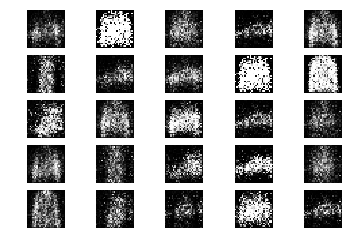

601 [D loss: 0.716285, acc.: 54.69%] [G loss: 1.218202]
602 [D loss: 0.648605, acc.: 67.19%] [G loss: 1.300804]
603 [D loss: 0.616375, acc.: 70.31%] [G loss: 1.243453]
604 [D loss: 0.711597, acc.: 54.69%] [G loss: 1.364500]
605 [D loss: 0.636139, acc.: 60.94%] [G loss: 1.248034]
606 [D loss: 0.587116, acc.: 64.06%] [G loss: 1.194834]
607 [D loss: 0.614567, acc.: 67.19%] [G loss: 1.219800]
608 [D loss: 0.619449, acc.: 64.06%] [G loss: 1.310004]
609 [D loss: 0.631068, acc.: 64.06%] [G loss: 1.244807]
610 [D loss: 0.549670, acc.: 68.75%] [G loss: 1.305884]
611 [D loss: 0.565778, acc.: 68.75%] [G loss: 1.199957]
612 [D loss: 0.693506, acc.: 57.81%] [G loss: 1.213665]
613 [D loss: 0.627683, acc.: 57.81%] [G loss: 1.189740]
614 [D loss: 0.629050, acc.: 59.38%] [G loss: 1.173248]
615 [D loss: 0.648043, acc.: 62.50%] [G loss: 1.288845]
616 [D loss: 0.663441, acc.: 62.50%] [G loss: 1.108065]
617 [D loss: 0.751307, acc.: 59.38%] [G loss: 1.186656]
618 [D loss: 0.576115, acc.: 73.44%] [G loss: 1.

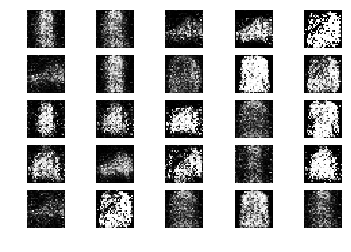

801 [D loss: 0.543114, acc.: 75.00%] [G loss: 1.347803]
802 [D loss: 0.570985, acc.: 70.31%] [G loss: 1.285032]
803 [D loss: 0.536870, acc.: 73.44%] [G loss: 1.401243]
804 [D loss: 0.601175, acc.: 62.50%] [G loss: 1.285466]
805 [D loss: 0.572717, acc.: 81.25%] [G loss: 1.384059]
806 [D loss: 0.606256, acc.: 71.88%] [G loss: 1.290129]
807 [D loss: 0.672743, acc.: 54.69%] [G loss: 1.415889]
808 [D loss: 0.600295, acc.: 76.56%] [G loss: 1.127525]
809 [D loss: 0.687277, acc.: 57.81%] [G loss: 1.027462]
810 [D loss: 0.524301, acc.: 75.00%] [G loss: 1.286051]
811 [D loss: 0.555555, acc.: 67.19%] [G loss: 1.355667]
812 [D loss: 0.543839, acc.: 68.75%] [G loss: 1.320788]
813 [D loss: 0.577576, acc.: 65.62%] [G loss: 1.359420]
814 [D loss: 0.544686, acc.: 70.31%] [G loss: 1.296508]
815 [D loss: 0.598233, acc.: 73.44%] [G loss: 1.420574]
816 [D loss: 0.709576, acc.: 62.50%] [G loss: 1.494226]
817 [D loss: 0.558888, acc.: 78.12%] [G loss: 1.245895]
818 [D loss: 0.630277, acc.: 62.50%] [G loss: 1.

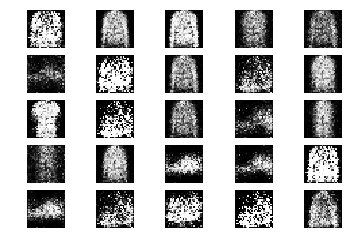

1001 [D loss: 0.626928, acc.: 76.56%] [G loss: 1.031341]
1002 [D loss: 0.604636, acc.: 64.06%] [G loss: 1.129143]
1003 [D loss: 0.608247, acc.: 70.31%] [G loss: 1.128866]
1004 [D loss: 0.708628, acc.: 57.81%] [G loss: 1.097328]
1005 [D loss: 0.568866, acc.: 70.31%] [G loss: 1.076522]
1006 [D loss: 0.544062, acc.: 76.56%] [G loss: 1.103525]
1007 [D loss: 0.679980, acc.: 56.25%] [G loss: 1.020089]
1008 [D loss: 0.550546, acc.: 75.00%] [G loss: 1.141073]
1009 [D loss: 0.571824, acc.: 64.06%] [G loss: 1.138646]
1010 [D loss: 0.541456, acc.: 73.44%] [G loss: 1.197614]
1011 [D loss: 0.683182, acc.: 59.38%] [G loss: 1.155587]
1012 [D loss: 0.552362, acc.: 73.44%] [G loss: 1.213804]
1013 [D loss: 0.607753, acc.: 68.75%] [G loss: 1.218130]
1014 [D loss: 0.525079, acc.: 76.56%] [G loss: 1.200222]
1015 [D loss: 0.685083, acc.: 51.56%] [G loss: 1.056440]
1016 [D loss: 0.704181, acc.: 51.56%] [G loss: 1.035759]
1017 [D loss: 0.672965, acc.: 48.44%] [G loss: 1.029111]
1018 [D loss: 0.609826, acc.: 6

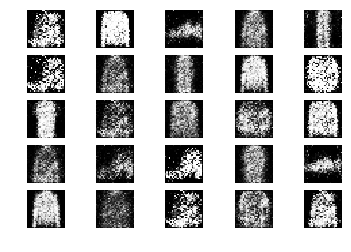

1201 [D loss: 0.643813, acc.: 57.81%] [G loss: 1.011050]
1202 [D loss: 0.702955, acc.: 57.81%] [G loss: 0.955734]
1203 [D loss: 0.661001, acc.: 56.25%] [G loss: 1.025509]
1204 [D loss: 0.637495, acc.: 64.06%] [G loss: 0.902936]
1205 [D loss: 0.636527, acc.: 65.62%] [G loss: 0.883829]
1206 [D loss: 0.622089, acc.: 60.94%] [G loss: 0.980868]
1207 [D loss: 0.681495, acc.: 53.12%] [G loss: 1.043172]
1208 [D loss: 0.522845, acc.: 82.81%] [G loss: 1.087155]
1209 [D loss: 0.556426, acc.: 76.56%] [G loss: 1.019093]
1210 [D loss: 0.728384, acc.: 53.12%] [G loss: 0.969393]
1211 [D loss: 0.645945, acc.: 54.69%] [G loss: 0.883720]
1212 [D loss: 0.628299, acc.: 65.62%] [G loss: 0.990397]
1213 [D loss: 0.686702, acc.: 59.38%] [G loss: 1.013540]
1214 [D loss: 0.615364, acc.: 65.62%] [G loss: 0.968200]
1215 [D loss: 0.653630, acc.: 62.50%] [G loss: 0.961897]
1216 [D loss: 0.612660, acc.: 62.50%] [G loss: 0.984373]
1217 [D loss: 0.648020, acc.: 57.81%] [G loss: 0.956791]
1218 [D loss: 0.720469, acc.: 5

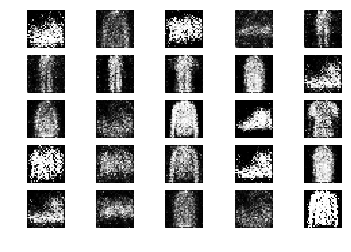

1401 [D loss: 0.645931, acc.: 59.38%] [G loss: 0.923374]
1402 [D loss: 0.665617, acc.: 60.94%] [G loss: 0.940145]
1403 [D loss: 0.700013, acc.: 54.69%] [G loss: 0.903313]
1404 [D loss: 0.682190, acc.: 56.25%] [G loss: 0.911541]
1405 [D loss: 0.624497, acc.: 65.62%] [G loss: 0.976267]
1406 [D loss: 0.683109, acc.: 56.25%] [G loss: 0.901683]
1407 [D loss: 0.539246, acc.: 79.69%] [G loss: 1.087649]
1408 [D loss: 0.697752, acc.: 53.12%] [G loss: 0.972101]
1409 [D loss: 0.646934, acc.: 57.81%] [G loss: 1.017683]
1410 [D loss: 0.674552, acc.: 59.38%] [G loss: 0.987277]
1411 [D loss: 0.664866, acc.: 54.69%] [G loss: 0.962582]
1412 [D loss: 0.694660, acc.: 60.94%] [G loss: 0.903678]
1413 [D loss: 0.652797, acc.: 68.75%] [G loss: 0.884624]
1414 [D loss: 0.669256, acc.: 59.38%] [G loss: 0.870713]
1415 [D loss: 0.659174, acc.: 64.06%] [G loss: 0.886164]
1416 [D loss: 0.653061, acc.: 70.31%] [G loss: 0.840123]
1417 [D loss: 0.674738, acc.: 60.94%] [G loss: 0.832368]
1418 [D loss: 0.704031, acc.: 5

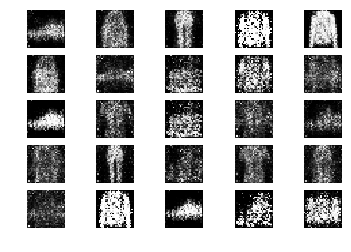

1601 [D loss: 0.553801, acc.: 71.88%] [G loss: 0.915049]
1602 [D loss: 0.586835, acc.: 71.88%] [G loss: 0.936535]
1603 [D loss: 0.756720, acc.: 46.88%] [G loss: 1.011679]
1604 [D loss: 0.652457, acc.: 64.06%] [G loss: 0.830441]
1605 [D loss: 0.670043, acc.: 51.56%] [G loss: 0.862214]
1606 [D loss: 0.682147, acc.: 50.00%] [G loss: 0.934733]
1607 [D loss: 0.700593, acc.: 59.38%] [G loss: 0.923340]
1608 [D loss: 0.583963, acc.: 67.19%] [G loss: 0.975598]
1609 [D loss: 0.720181, acc.: 54.69%] [G loss: 0.989710]
1610 [D loss: 0.635089, acc.: 65.62%] [G loss: 0.993748]
1611 [D loss: 0.666052, acc.: 65.62%] [G loss: 0.873327]
1612 [D loss: 0.535988, acc.: 81.25%] [G loss: 0.895708]
1613 [D loss: 0.611749, acc.: 60.94%] [G loss: 0.946231]
1614 [D loss: 0.621839, acc.: 64.06%] [G loss: 0.897819]
1615 [D loss: 0.637260, acc.: 62.50%] [G loss: 0.897303]
1616 [D loss: 0.682977, acc.: 62.50%] [G loss: 0.928735]
1617 [D loss: 0.664105, acc.: 56.25%] [G loss: 0.948334]
1618 [D loss: 0.614295, acc.: 6

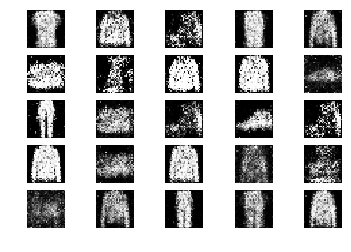

1801 [D loss: 0.576250, acc.: 73.44%] [G loss: 1.000431]
1802 [D loss: 0.549076, acc.: 78.12%] [G loss: 1.038692]
1803 [D loss: 0.663298, acc.: 56.25%] [G loss: 0.933899]
1804 [D loss: 0.604446, acc.: 68.75%] [G loss: 0.911301]
1805 [D loss: 0.703882, acc.: 62.50%] [G loss: 0.968339]
1806 [D loss: 0.634958, acc.: 67.19%] [G loss: 0.966927]
1807 [D loss: 0.550191, acc.: 75.00%] [G loss: 0.978499]
1808 [D loss: 0.629028, acc.: 62.50%] [G loss: 0.970782]
1809 [D loss: 0.612374, acc.: 62.50%] [G loss: 0.894001]
1810 [D loss: 0.637926, acc.: 59.38%] [G loss: 0.918877]
1811 [D loss: 0.606921, acc.: 64.06%] [G loss: 0.964223]
1812 [D loss: 0.556765, acc.: 78.12%] [G loss: 0.921354]
1813 [D loss: 0.575789, acc.: 73.44%] [G loss: 0.905249]
1814 [D loss: 0.594141, acc.: 70.31%] [G loss: 0.958205]
1815 [D loss: 0.562262, acc.: 73.44%] [G loss: 0.899035]
1816 [D loss: 0.667301, acc.: 60.94%] [G loss: 0.961340]
1817 [D loss: 0.541719, acc.: 76.56%] [G loss: 0.977736]
1818 [D loss: 0.639084, acc.: 5

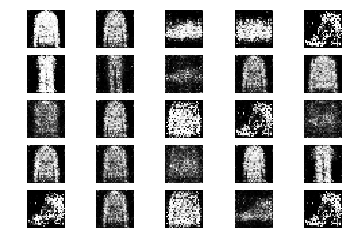

2001 [D loss: 0.626222, acc.: 70.31%] [G loss: 0.908399]
2002 [D loss: 0.571926, acc.: 71.88%] [G loss: 0.887890]
2003 [D loss: 0.596147, acc.: 68.75%] [G loss: 0.879933]
2004 [D loss: 0.582475, acc.: 67.19%] [G loss: 0.939194]
2005 [D loss: 0.635494, acc.: 64.06%] [G loss: 1.060260]
2006 [D loss: 0.577263, acc.: 70.31%] [G loss: 0.968716]
2007 [D loss: 0.634516, acc.: 57.81%] [G loss: 0.889761]
2008 [D loss: 0.607849, acc.: 59.38%] [G loss: 0.909074]
2009 [D loss: 0.610897, acc.: 68.75%] [G loss: 0.964508]
2010 [D loss: 0.615489, acc.: 65.62%] [G loss: 1.102718]
2011 [D loss: 0.681944, acc.: 60.94%] [G loss: 0.961725]
2012 [D loss: 0.700496, acc.: 59.38%] [G loss: 0.914858]
2013 [D loss: 0.638723, acc.: 65.62%] [G loss: 0.991278]
2014 [D loss: 0.622839, acc.: 64.06%] [G loss: 0.923324]
2015 [D loss: 0.550299, acc.: 71.88%] [G loss: 1.074605]
2016 [D loss: 0.730082, acc.: 53.12%] [G loss: 1.016858]
2017 [D loss: 0.662124, acc.: 59.38%] [G loss: 1.059336]
2018 [D loss: 0.643088, acc.: 6

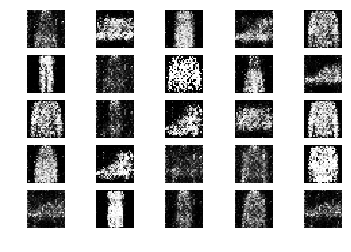

2201 [D loss: 0.617341, acc.: 67.19%] [G loss: 1.004073]
2202 [D loss: 0.628289, acc.: 59.38%] [G loss: 1.062113]
2203 [D loss: 0.611858, acc.: 64.06%] [G loss: 1.106649]
2204 [D loss: 0.606753, acc.: 65.62%] [G loss: 1.048868]
2205 [D loss: 0.640692, acc.: 68.75%] [G loss: 0.926908]
2206 [D loss: 0.621253, acc.: 70.31%] [G loss: 0.974728]
2207 [D loss: 0.598139, acc.: 65.62%] [G loss: 0.971418]
2208 [D loss: 0.666939, acc.: 57.81%] [G loss: 0.968488]
2209 [D loss: 0.612211, acc.: 71.88%] [G loss: 0.907332]
2210 [D loss: 0.634157, acc.: 65.62%] [G loss: 0.980769]
2211 [D loss: 0.640833, acc.: 60.94%] [G loss: 0.994778]
2212 [D loss: 0.644368, acc.: 62.50%] [G loss: 0.955525]
2213 [D loss: 0.536689, acc.: 71.88%] [G loss: 1.041268]
2214 [D loss: 0.650528, acc.: 60.94%] [G loss: 0.979997]
2215 [D loss: 0.584438, acc.: 71.88%] [G loss: 0.991381]
2216 [D loss: 0.541386, acc.: 76.56%] [G loss: 1.053174]
2217 [D loss: 0.662689, acc.: 62.50%] [G loss: 1.048069]
2218 [D loss: 0.696332, acc.: 5

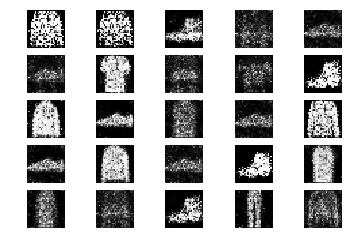

2401 [D loss: 0.779106, acc.: 54.69%] [G loss: 1.004434]
2402 [D loss: 0.647154, acc.: 57.81%] [G loss: 1.100803]
2403 [D loss: 0.547275, acc.: 71.88%] [G loss: 0.995167]
2404 [D loss: 0.550021, acc.: 70.31%] [G loss: 1.001266]
2405 [D loss: 0.633945, acc.: 59.38%] [G loss: 1.051833]
2406 [D loss: 0.626833, acc.: 65.62%] [G loss: 0.980418]
2407 [D loss: 0.671132, acc.: 59.38%] [G loss: 1.005886]
2408 [D loss: 0.699566, acc.: 59.38%] [G loss: 1.075638]
2409 [D loss: 0.638329, acc.: 65.62%] [G loss: 0.965199]
2410 [D loss: 0.573452, acc.: 68.75%] [G loss: 0.896092]
2411 [D loss: 0.535337, acc.: 76.56%] [G loss: 1.031884]
2412 [D loss: 0.657215, acc.: 59.38%] [G loss: 0.965394]
2413 [D loss: 0.728675, acc.: 57.81%] [G loss: 0.964899]
2414 [D loss: 0.660640, acc.: 59.38%] [G loss: 1.003842]
2415 [D loss: 0.629253, acc.: 60.94%] [G loss: 1.055770]
2416 [D loss: 0.640043, acc.: 64.06%] [G loss: 0.897747]
2417 [D loss: 0.630361, acc.: 70.31%] [G loss: 0.900633]
2418 [D loss: 0.592137, acc.: 6

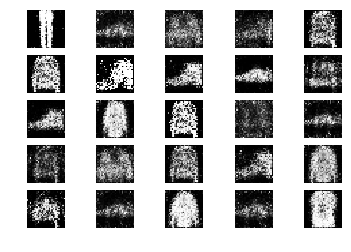

2601 [D loss: 0.587369, acc.: 65.62%] [G loss: 1.075418]
2602 [D loss: 0.719535, acc.: 57.81%] [G loss: 1.035026]
2603 [D loss: 0.620770, acc.: 60.94%] [G loss: 1.174418]
2604 [D loss: 0.554950, acc.: 73.44%] [G loss: 1.167625]
2605 [D loss: 0.643399, acc.: 62.50%] [G loss: 1.034728]
2606 [D loss: 0.683486, acc.: 54.69%] [G loss: 1.005482]
2607 [D loss: 0.562797, acc.: 65.62%] [G loss: 1.010086]
2608 [D loss: 0.626471, acc.: 62.50%] [G loss: 1.119014]
2609 [D loss: 0.625668, acc.: 68.75%] [G loss: 0.989170]
2610 [D loss: 0.620768, acc.: 65.62%] [G loss: 0.964613]
2611 [D loss: 0.564902, acc.: 75.00%] [G loss: 1.042737]
2612 [D loss: 0.634118, acc.: 57.81%] [G loss: 1.057378]
2613 [D loss: 0.627084, acc.: 65.62%] [G loss: 1.070521]
2614 [D loss: 0.606717, acc.: 65.62%] [G loss: 1.004567]
2615 [D loss: 0.540415, acc.: 73.44%] [G loss: 1.009850]
2616 [D loss: 0.593759, acc.: 68.75%] [G loss: 0.977078]
2617 [D loss: 0.589331, acc.: 60.94%] [G loss: 0.994843]
2618 [D loss: 0.635473, acc.: 6

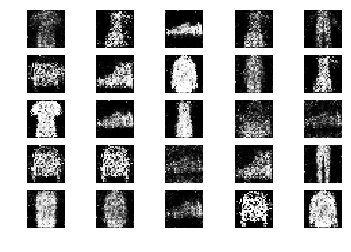

2801 [D loss: 0.639801, acc.: 65.62%] [G loss: 1.142012]
2802 [D loss: 0.694691, acc.: 48.44%] [G loss: 1.025191]
2803 [D loss: 0.623586, acc.: 64.06%] [G loss: 1.074775]
2804 [D loss: 0.572560, acc.: 71.88%] [G loss: 1.027828]
2805 [D loss: 0.650723, acc.: 57.81%] [G loss: 0.998716]
2806 [D loss: 0.607174, acc.: 64.06%] [G loss: 1.136020]
2807 [D loss: 0.658387, acc.: 59.38%] [G loss: 1.069432]
2808 [D loss: 0.576747, acc.: 68.75%] [G loss: 1.132064]
2809 [D loss: 0.626020, acc.: 67.19%] [G loss: 0.918961]
2810 [D loss: 0.622137, acc.: 62.50%] [G loss: 1.015344]
2811 [D loss: 0.604208, acc.: 62.50%] [G loss: 1.053127]
2812 [D loss: 0.685698, acc.: 59.38%] [G loss: 1.123445]
2813 [D loss: 0.680958, acc.: 65.62%] [G loss: 1.167934]
2814 [D loss: 0.676522, acc.: 62.50%] [G loss: 0.995148]
2815 [D loss: 0.528792, acc.: 75.00%] [G loss: 1.018957]
2816 [D loss: 0.578582, acc.: 67.19%] [G loss: 1.052764]
2817 [D loss: 0.663261, acc.: 60.94%] [G loss: 1.256231]
2818 [D loss: 0.647076, acc.: 6

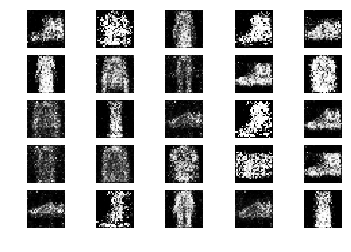

3001 [D loss: 0.662688, acc.: 60.94%] [G loss: 1.038223]
3002 [D loss: 0.671762, acc.: 62.50%] [G loss: 1.041914]
3003 [D loss: 0.595177, acc.: 70.31%] [G loss: 0.939113]
3004 [D loss: 0.646085, acc.: 68.75%] [G loss: 1.006384]
3005 [D loss: 0.569626, acc.: 65.62%] [G loss: 0.962292]
3006 [D loss: 0.679587, acc.: 65.62%] [G loss: 1.005245]
3007 [D loss: 0.653533, acc.: 62.50%] [G loss: 1.058979]
3008 [D loss: 0.619950, acc.: 59.38%] [G loss: 0.982787]
3009 [D loss: 0.593663, acc.: 70.31%] [G loss: 0.987785]
3010 [D loss: 0.587619, acc.: 78.12%] [G loss: 0.992783]
3011 [D loss: 0.576796, acc.: 70.31%] [G loss: 0.998885]
3012 [D loss: 0.546901, acc.: 75.00%] [G loss: 1.073517]
3013 [D loss: 0.616116, acc.: 65.62%] [G loss: 1.006464]
3014 [D loss: 0.708515, acc.: 50.00%] [G loss: 0.988493]
3015 [D loss: 0.661389, acc.: 56.25%] [G loss: 0.978684]
3016 [D loss: 0.637375, acc.: 65.62%] [G loss: 1.016408]
3017 [D loss: 0.605378, acc.: 75.00%] [G loss: 0.954494]
3018 [D loss: 0.598987, acc.: 6

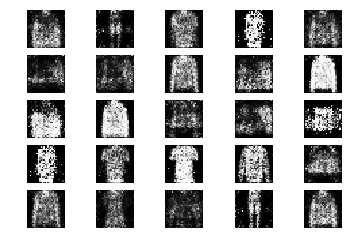

3201 [D loss: 0.634228, acc.: 62.50%] [G loss: 0.831385]
3202 [D loss: 0.658682, acc.: 67.19%] [G loss: 0.877511]
3203 [D loss: 0.620751, acc.: 70.31%] [G loss: 0.920580]
3204 [D loss: 0.589516, acc.: 65.62%] [G loss: 0.872831]
3205 [D loss: 0.711202, acc.: 51.56%] [G loss: 0.900080]
3206 [D loss: 0.649114, acc.: 56.25%] [G loss: 0.933538]
3207 [D loss: 0.643402, acc.: 62.50%] [G loss: 0.948794]
3208 [D loss: 0.606601, acc.: 62.50%] [G loss: 0.946039]
3209 [D loss: 0.635513, acc.: 60.94%] [G loss: 0.913582]
3210 [D loss: 0.644772, acc.: 71.88%] [G loss: 0.992520]
3211 [D loss: 0.596874, acc.: 65.62%] [G loss: 0.976399]
3212 [D loss: 0.705861, acc.: 46.88%] [G loss: 0.971761]
3213 [D loss: 0.633497, acc.: 65.62%] [G loss: 1.038078]
3214 [D loss: 0.724527, acc.: 62.50%] [G loss: 0.942316]
3215 [D loss: 0.607219, acc.: 67.19%] [G loss: 0.797002]
3216 [D loss: 0.575004, acc.: 64.06%] [G loss: 0.925218]
3217 [D loss: 0.575685, acc.: 64.06%] [G loss: 0.885589]
3218 [D loss: 0.698667, acc.: 5

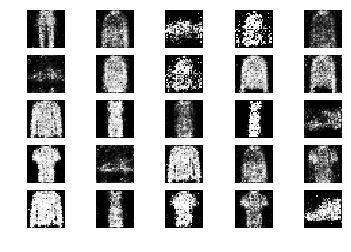

3401 [D loss: 0.681101, acc.: 48.44%] [G loss: 0.975549]
3402 [D loss: 0.619004, acc.: 59.38%] [G loss: 0.934100]
3403 [D loss: 0.594719, acc.: 70.31%] [G loss: 0.907517]
3404 [D loss: 0.641238, acc.: 64.06%] [G loss: 0.910509]
3405 [D loss: 0.584887, acc.: 75.00%] [G loss: 0.866753]
3406 [D loss: 0.703379, acc.: 46.88%] [G loss: 0.946032]
3407 [D loss: 0.618917, acc.: 60.94%] [G loss: 0.943290]
3408 [D loss: 0.629462, acc.: 65.62%] [G loss: 0.934494]
3409 [D loss: 0.659972, acc.: 62.50%] [G loss: 1.013964]
3410 [D loss: 0.592262, acc.: 71.88%] [G loss: 1.015537]
3411 [D loss: 0.734595, acc.: 54.69%] [G loss: 0.945294]
3412 [D loss: 0.638176, acc.: 65.62%] [G loss: 0.998080]
3413 [D loss: 0.524720, acc.: 79.69%] [G loss: 0.960739]
3414 [D loss: 0.538671, acc.: 75.00%] [G loss: 1.031685]
3415 [D loss: 0.640257, acc.: 54.69%] [G loss: 1.027299]
3416 [D loss: 0.641979, acc.: 64.06%] [G loss: 1.068680]
3417 [D loss: 0.547135, acc.: 73.44%] [G loss: 1.046889]
3418 [D loss: 0.533873, acc.: 7

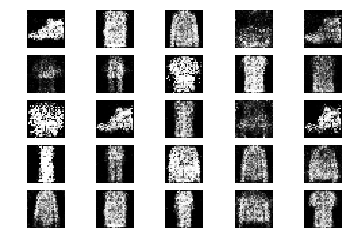

3601 [D loss: 0.595298, acc.: 70.31%] [G loss: 1.029136]
3602 [D loss: 0.643709, acc.: 57.81%] [G loss: 1.094937]
3603 [D loss: 0.654695, acc.: 59.38%] [G loss: 1.138593]
3604 [D loss: 0.561566, acc.: 79.69%] [G loss: 1.080072]
3605 [D loss: 0.637120, acc.: 73.44%] [G loss: 0.982142]
3606 [D loss: 0.587959, acc.: 68.75%] [G loss: 0.964521]
3607 [D loss: 0.632811, acc.: 64.06%] [G loss: 0.966158]
3608 [D loss: 0.555379, acc.: 71.88%] [G loss: 0.995123]
3609 [D loss: 0.613903, acc.: 67.19%] [G loss: 1.052284]
3610 [D loss: 0.724600, acc.: 57.81%] [G loss: 1.116818]
3611 [D loss: 0.583257, acc.: 71.88%] [G loss: 1.024146]
3612 [D loss: 0.531200, acc.: 76.56%] [G loss: 1.063776]
3613 [D loss: 0.625850, acc.: 68.75%] [G loss: 0.961132]
3614 [D loss: 0.620218, acc.: 70.31%] [G loss: 0.903695]
3615 [D loss: 0.645199, acc.: 62.50%] [G loss: 0.914099]
3616 [D loss: 0.656585, acc.: 67.19%] [G loss: 0.908980]
3617 [D loss: 0.675399, acc.: 59.38%] [G loss: 0.970021]
3618 [D loss: 0.643242, acc.: 6

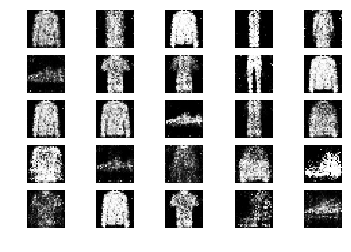

3801 [D loss: 0.626794, acc.: 75.00%] [G loss: 0.896365]
3802 [D loss: 0.648090, acc.: 57.81%] [G loss: 0.973482]
3803 [D loss: 0.618787, acc.: 65.62%] [G loss: 0.982028]
3804 [D loss: 0.641205, acc.: 62.50%] [G loss: 1.068694]
3805 [D loss: 0.598931, acc.: 67.19%] [G loss: 1.063549]
3806 [D loss: 0.650510, acc.: 53.12%] [G loss: 0.940058]
3807 [D loss: 0.683528, acc.: 54.69%] [G loss: 0.983526]
3808 [D loss: 0.584391, acc.: 68.75%] [G loss: 1.045888]
3809 [D loss: 0.636337, acc.: 68.75%] [G loss: 1.083763]
3810 [D loss: 0.696884, acc.: 56.25%] [G loss: 0.963325]
3811 [D loss: 0.609341, acc.: 65.62%] [G loss: 1.036868]
3812 [D loss: 0.718126, acc.: 51.56%] [G loss: 1.075617]
3813 [D loss: 0.652552, acc.: 68.75%] [G loss: 1.028436]
3814 [D loss: 0.623733, acc.: 62.50%] [G loss: 0.960187]
3815 [D loss: 0.552110, acc.: 79.69%] [G loss: 1.031022]
3816 [D loss: 0.570962, acc.: 71.88%] [G loss: 1.057783]
3817 [D loss: 0.555461, acc.: 73.44%] [G loss: 0.982958]
3818 [D loss: 0.621510, acc.: 6

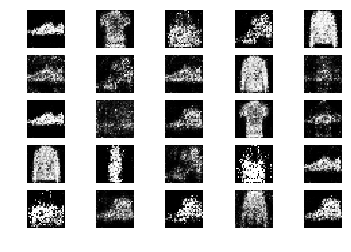

4001 [D loss: 0.481312, acc.: 84.38%] [G loss: 1.162096]
4002 [D loss: 0.630215, acc.: 56.25%] [G loss: 1.054097]
4003 [D loss: 0.675078, acc.: 57.81%] [G loss: 1.114342]
4004 [D loss: 0.574407, acc.: 65.62%] [G loss: 1.033570]
4005 [D loss: 0.634501, acc.: 56.25%] [G loss: 1.230858]
4006 [D loss: 0.686142, acc.: 56.25%] [G loss: 1.038481]
4007 [D loss: 0.606965, acc.: 59.38%] [G loss: 0.989356]
4008 [D loss: 0.703020, acc.: 57.81%] [G loss: 0.965879]
4009 [D loss: 0.565508, acc.: 67.19%] [G loss: 1.031219]
4010 [D loss: 0.637913, acc.: 57.81%] [G loss: 1.035911]
4011 [D loss: 0.612983, acc.: 60.94%] [G loss: 1.058638]
4012 [D loss: 0.534907, acc.: 73.44%] [G loss: 1.080338]
4013 [D loss: 0.637704, acc.: 56.25%] [G loss: 0.952953]
4014 [D loss: 0.659584, acc.: 59.38%] [G loss: 1.044248]
4015 [D loss: 0.557823, acc.: 76.56%] [G loss: 1.072903]
4016 [D loss: 0.548907, acc.: 76.56%] [G loss: 1.131592]
4017 [D loss: 0.591494, acc.: 65.62%] [G loss: 1.023376]
4018 [D loss: 0.673769, acc.: 5

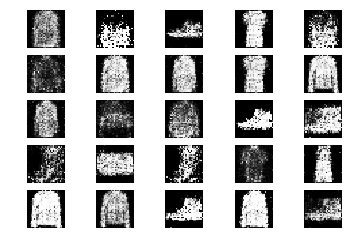

4201 [D loss: 0.585925, acc.: 62.50%] [G loss: 1.084190]
4202 [D loss: 0.570386, acc.: 68.75%] [G loss: 1.054785]
4203 [D loss: 0.601626, acc.: 71.88%] [G loss: 1.001623]
4204 [D loss: 0.624646, acc.: 65.62%] [G loss: 0.974990]
4205 [D loss: 0.700679, acc.: 62.50%] [G loss: 1.060684]
4206 [D loss: 0.593431, acc.: 65.62%] [G loss: 1.131260]
4207 [D loss: 0.606696, acc.: 62.50%] [G loss: 1.048844]
4208 [D loss: 0.680561, acc.: 54.69%] [G loss: 0.932712]
4209 [D loss: 0.626005, acc.: 59.38%] [G loss: 1.146876]
4210 [D loss: 0.577140, acc.: 67.19%] [G loss: 1.048610]
4211 [D loss: 0.682223, acc.: 51.56%] [G loss: 1.059599]
4212 [D loss: 0.702282, acc.: 54.69%] [G loss: 1.038846]
4213 [D loss: 0.597983, acc.: 71.88%] [G loss: 1.087996]
4214 [D loss: 0.564562, acc.: 76.56%] [G loss: 0.999531]
4215 [D loss: 0.614160, acc.: 64.06%] [G loss: 1.110977]
4216 [D loss: 0.569206, acc.: 73.44%] [G loss: 1.071540]
4217 [D loss: 0.634459, acc.: 62.50%] [G loss: 1.205939]
4218 [D loss: 0.589142, acc.: 6

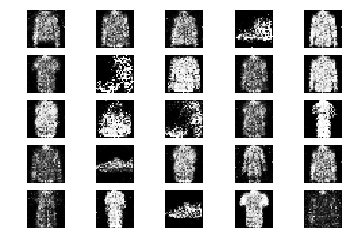

4401 [D loss: 0.589948, acc.: 67.19%] [G loss: 1.083913]
4402 [D loss: 0.523246, acc.: 75.00%] [G loss: 1.088281]
4403 [D loss: 0.651900, acc.: 64.06%] [G loss: 0.895225]
4404 [D loss: 0.660844, acc.: 56.25%] [G loss: 1.079307]
4405 [D loss: 0.596526, acc.: 64.06%] [G loss: 1.167620]
4406 [D loss: 0.639947, acc.: 62.50%] [G loss: 0.943693]
4407 [D loss: 0.667653, acc.: 56.25%] [G loss: 1.130841]
4408 [D loss: 0.596577, acc.: 67.19%] [G loss: 1.111754]
4409 [D loss: 0.695738, acc.: 50.00%] [G loss: 1.164096]
4410 [D loss: 0.601663, acc.: 59.38%] [G loss: 0.981831]
4411 [D loss: 0.680377, acc.: 45.31%] [G loss: 0.934919]
4412 [D loss: 0.617566, acc.: 64.06%] [G loss: 0.949626]
4413 [D loss: 0.654147, acc.: 65.62%] [G loss: 1.053738]
4414 [D loss: 0.636806, acc.: 56.25%] [G loss: 1.086865]
4415 [D loss: 0.709897, acc.: 57.81%] [G loss: 1.092317]
4416 [D loss: 0.596364, acc.: 64.06%] [G loss: 1.085484]
4417 [D loss: 0.708196, acc.: 57.81%] [G loss: 1.120235]
4418 [D loss: 0.669226, acc.: 5

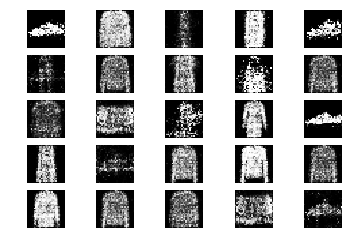

4601 [D loss: 0.580977, acc.: 60.94%] [G loss: 1.000949]
4602 [D loss: 0.567887, acc.: 71.88%] [G loss: 1.070289]
4603 [D loss: 0.527822, acc.: 73.44%] [G loss: 1.072703]
4604 [D loss: 0.692145, acc.: 65.62%] [G loss: 1.162364]
4605 [D loss: 0.748945, acc.: 57.81%] [G loss: 1.018368]
4606 [D loss: 0.707519, acc.: 54.69%] [G loss: 1.162710]
4607 [D loss: 0.583139, acc.: 75.00%] [G loss: 1.062976]
4608 [D loss: 0.595597, acc.: 60.94%] [G loss: 1.135313]
4609 [D loss: 0.594617, acc.: 70.31%] [G loss: 1.022040]
4610 [D loss: 0.593364, acc.: 64.06%] [G loss: 1.033182]
4611 [D loss: 0.579741, acc.: 65.62%] [G loss: 0.977314]
4612 [D loss: 0.592772, acc.: 71.88%] [G loss: 0.968937]
4613 [D loss: 0.576343, acc.: 65.62%] [G loss: 1.148920]
4614 [D loss: 0.562397, acc.: 71.88%] [G loss: 1.049087]
4615 [D loss: 0.636076, acc.: 70.31%] [G loss: 1.062220]
4616 [D loss: 0.607514, acc.: 64.06%] [G loss: 1.047153]
4617 [D loss: 0.586692, acc.: 62.50%] [G loss: 0.998199]
4618 [D loss: 0.593032, acc.: 6

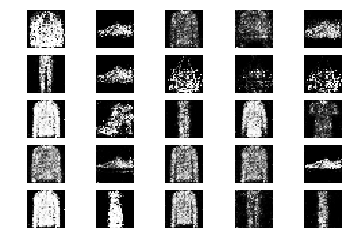

4801 [D loss: 0.593613, acc.: 64.06%] [G loss: 1.008925]
4802 [D loss: 0.551002, acc.: 70.31%] [G loss: 0.927648]
4803 [D loss: 0.536471, acc.: 75.00%] [G loss: 1.051975]
4804 [D loss: 0.626743, acc.: 56.25%] [G loss: 1.120260]
4805 [D loss: 0.543670, acc.: 68.75%] [G loss: 1.171896]
4806 [D loss: 0.644243, acc.: 62.50%] [G loss: 1.085196]
4807 [D loss: 0.612952, acc.: 71.88%] [G loss: 1.056030]
4808 [D loss: 0.694884, acc.: 53.12%] [G loss: 1.108142]
4809 [D loss: 0.619683, acc.: 60.94%] [G loss: 1.106767]
4810 [D loss: 0.552408, acc.: 73.44%] [G loss: 1.033695]
4811 [D loss: 0.559739, acc.: 75.00%] [G loss: 1.086884]
4812 [D loss: 0.634144, acc.: 62.50%] [G loss: 0.953480]
4813 [D loss: 0.698211, acc.: 56.25%] [G loss: 1.092467]
4814 [D loss: 0.583888, acc.: 64.06%] [G loss: 1.007960]
4815 [D loss: 0.634411, acc.: 54.69%] [G loss: 0.969226]
4816 [D loss: 0.559247, acc.: 73.44%] [G loss: 1.114449]
4817 [D loss: 0.632086, acc.: 64.06%] [G loss: 1.047482]
4818 [D loss: 0.622844, acc.: 6

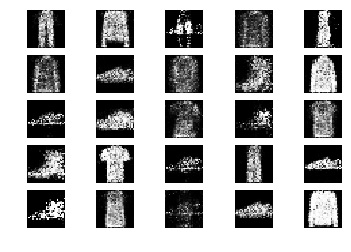

5001 [D loss: 0.601024, acc.: 71.88%] [G loss: 0.877765]
5002 [D loss: 0.563876, acc.: 70.31%] [G loss: 0.929636]
5003 [D loss: 0.613009, acc.: 65.62%] [G loss: 0.969163]
5004 [D loss: 0.610737, acc.: 65.62%] [G loss: 0.993300]
5005 [D loss: 0.629600, acc.: 67.19%] [G loss: 0.978826]
5006 [D loss: 0.663934, acc.: 57.81%] [G loss: 0.951167]
5007 [D loss: 0.645552, acc.: 62.50%] [G loss: 0.917953]
5008 [D loss: 0.607190, acc.: 60.94%] [G loss: 1.001042]
5009 [D loss: 0.545095, acc.: 78.12%] [G loss: 1.021979]
5010 [D loss: 0.672861, acc.: 54.69%] [G loss: 0.972097]
5011 [D loss: 0.621360, acc.: 53.12%] [G loss: 1.050527]
5012 [D loss: 0.615544, acc.: 60.94%] [G loss: 1.074072]
5013 [D loss: 0.593696, acc.: 68.75%] [G loss: 0.962802]
5014 [D loss: 0.634409, acc.: 64.06%] [G loss: 0.962943]
5015 [D loss: 0.633629, acc.: 56.25%] [G loss: 0.976156]
5016 [D loss: 0.671713, acc.: 56.25%] [G loss: 1.056663]
5017 [D loss: 0.593548, acc.: 67.19%] [G loss: 1.076630]
5018 [D loss: 0.556461, acc.: 6

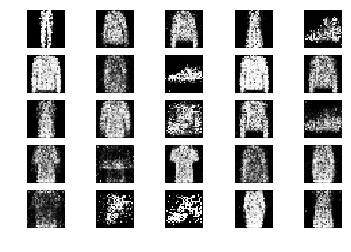

5201 [D loss: 0.611821, acc.: 68.75%] [G loss: 0.974806]
5202 [D loss: 0.617641, acc.: 53.12%] [G loss: 0.963159]
5203 [D loss: 0.652268, acc.: 53.12%] [G loss: 0.987700]
5204 [D loss: 0.658320, acc.: 60.94%] [G loss: 1.071070]
5205 [D loss: 0.622613, acc.: 64.06%] [G loss: 1.052615]
5206 [D loss: 0.615125, acc.: 67.19%] [G loss: 1.129000]
5207 [D loss: 0.608336, acc.: 62.50%] [G loss: 1.061063]
5208 [D loss: 0.642409, acc.: 56.25%] [G loss: 1.196847]
5209 [D loss: 0.661596, acc.: 59.38%] [G loss: 1.027190]
5210 [D loss: 0.676371, acc.: 51.56%] [G loss: 0.905087]
5211 [D loss: 0.668213, acc.: 56.25%] [G loss: 1.015184]
5212 [D loss: 0.612740, acc.: 62.50%] [G loss: 1.012369]
5213 [D loss: 0.622497, acc.: 60.94%] [G loss: 1.042278]
5214 [D loss: 0.644517, acc.: 53.12%] [G loss: 1.037120]
5215 [D loss: 0.624349, acc.: 68.75%] [G loss: 1.028670]
5216 [D loss: 0.649871, acc.: 62.50%] [G loss: 0.930185]
5217 [D loss: 0.622894, acc.: 68.75%] [G loss: 0.995590]
5218 [D loss: 0.609293, acc.: 6

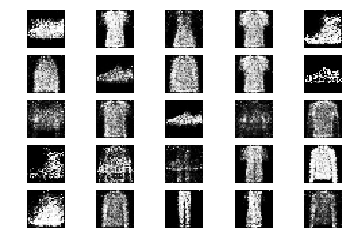

5401 [D loss: 0.616280, acc.: 68.75%] [G loss: 0.978948]
5402 [D loss: 0.651426, acc.: 60.94%] [G loss: 0.921657]
5403 [D loss: 0.655681, acc.: 60.94%] [G loss: 1.010799]
5404 [D loss: 0.630783, acc.: 65.62%] [G loss: 1.117084]
5405 [D loss: 0.694598, acc.: 46.88%] [G loss: 0.904904]
5406 [D loss: 0.693428, acc.: 50.00%] [G loss: 1.010826]
5407 [D loss: 0.559291, acc.: 71.88%] [G loss: 1.033309]
5408 [D loss: 0.539298, acc.: 71.88%] [G loss: 0.962443]
5409 [D loss: 0.576890, acc.: 71.88%] [G loss: 0.945691]
5410 [D loss: 0.679229, acc.: 56.25%] [G loss: 0.981891]
5411 [D loss: 0.655547, acc.: 59.38%] [G loss: 0.989147]
5412 [D loss: 0.663971, acc.: 56.25%] [G loss: 1.039900]
5413 [D loss: 0.577542, acc.: 76.56%] [G loss: 1.035081]
5414 [D loss: 0.703093, acc.: 51.56%] [G loss: 0.987323]
5415 [D loss: 0.627060, acc.: 68.75%] [G loss: 0.968785]
5416 [D loss: 0.643504, acc.: 65.62%] [G loss: 0.955893]
5417 [D loss: 0.583785, acc.: 70.31%] [G loss: 0.929136]
5418 [D loss: 0.781662, acc.: 5

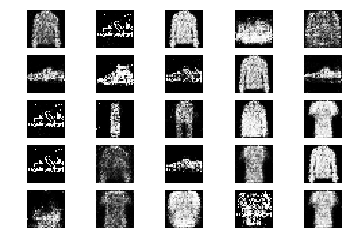

5601 [D loss: 0.650278, acc.: 60.94%] [G loss: 0.894913]
5602 [D loss: 0.605775, acc.: 73.44%] [G loss: 0.950299]
5603 [D loss: 0.591335, acc.: 71.88%] [G loss: 0.911295]
5604 [D loss: 0.643981, acc.: 64.06%] [G loss: 0.893608]
5605 [D loss: 0.613954, acc.: 60.94%] [G loss: 0.956154]
5606 [D loss: 0.614634, acc.: 68.75%] [G loss: 0.884428]
5607 [D loss: 0.680265, acc.: 57.81%] [G loss: 0.912361]
5608 [D loss: 0.625982, acc.: 60.94%] [G loss: 0.929407]
5609 [D loss: 0.599008, acc.: 65.62%] [G loss: 0.916738]
5610 [D loss: 0.621518, acc.: 54.69%] [G loss: 0.908121]
5611 [D loss: 0.678303, acc.: 57.81%] [G loss: 0.994812]
5612 [D loss: 0.697061, acc.: 54.69%] [G loss: 0.911445]
5613 [D loss: 0.656492, acc.: 57.81%] [G loss: 0.939645]
5614 [D loss: 0.588454, acc.: 71.88%] [G loss: 0.960826]
5615 [D loss: 0.681230, acc.: 62.50%] [G loss: 0.955714]
5616 [D loss: 0.639832, acc.: 59.38%] [G loss: 0.990282]
5617 [D loss: 0.647258, acc.: 64.06%] [G loss: 0.879695]
5618 [D loss: 0.664072, acc.: 6

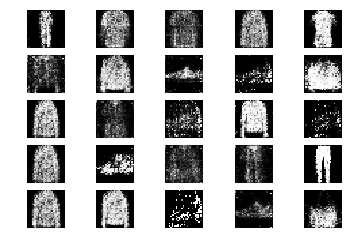

5801 [D loss: 0.661315, acc.: 53.12%] [G loss: 1.070425]
5802 [D loss: 0.565928, acc.: 71.88%] [G loss: 1.032836]
5803 [D loss: 0.619736, acc.: 67.19%] [G loss: 1.037789]
5804 [D loss: 0.553061, acc.: 73.44%] [G loss: 1.039949]
5805 [D loss: 0.613885, acc.: 70.31%] [G loss: 1.106454]
5806 [D loss: 0.680553, acc.: 48.44%] [G loss: 1.038646]
5807 [D loss: 0.553741, acc.: 70.31%] [G loss: 0.988606]
5808 [D loss: 0.576661, acc.: 65.62%] [G loss: 1.088269]
5809 [D loss: 0.581191, acc.: 64.06%] [G loss: 0.932547]
5810 [D loss: 0.630289, acc.: 65.62%] [G loss: 0.972621]
5811 [D loss: 0.643222, acc.: 56.25%] [G loss: 1.030387]
5812 [D loss: 0.667288, acc.: 59.38%] [G loss: 1.025524]
5813 [D loss: 0.571252, acc.: 70.31%] [G loss: 0.997065]
5814 [D loss: 0.591096, acc.: 62.50%] [G loss: 1.162058]
5815 [D loss: 0.605048, acc.: 65.62%] [G loss: 1.086013]
5816 [D loss: 0.639128, acc.: 67.19%] [G loss: 0.968257]
5817 [D loss: 0.609226, acc.: 65.62%] [G loss: 1.043651]
5818 [D loss: 0.660290, acc.: 5

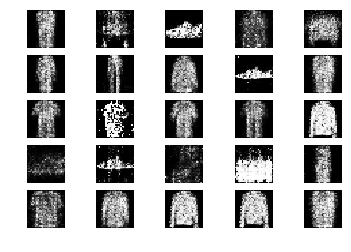

6001 [D loss: 0.618481, acc.: 68.75%] [G loss: 0.909368]
6002 [D loss: 0.572363, acc.: 67.19%] [G loss: 1.049944]
6003 [D loss: 0.628333, acc.: 67.19%] [G loss: 0.944995]
6004 [D loss: 0.635499, acc.: 54.69%] [G loss: 0.974713]
6005 [D loss: 0.693387, acc.: 59.38%] [G loss: 1.032411]
6006 [D loss: 0.659607, acc.: 51.56%] [G loss: 1.024571]
6007 [D loss: 0.633694, acc.: 62.50%] [G loss: 1.051164]
6008 [D loss: 0.599349, acc.: 64.06%] [G loss: 0.984106]
6009 [D loss: 0.615652, acc.: 68.75%] [G loss: 0.984930]
6010 [D loss: 0.619475, acc.: 68.75%] [G loss: 0.993305]
6011 [D loss: 0.668861, acc.: 51.56%] [G loss: 0.996960]
6012 [D loss: 0.600915, acc.: 70.31%] [G loss: 1.029240]
6013 [D loss: 0.620695, acc.: 60.94%] [G loss: 0.953774]
6014 [D loss: 0.607912, acc.: 65.62%] [G loss: 0.926161]
6015 [D loss: 0.624106, acc.: 71.88%] [G loss: 0.910225]
6016 [D loss: 0.661017, acc.: 65.62%] [G loss: 0.995154]
6017 [D loss: 0.524627, acc.: 73.44%] [G loss: 1.032634]
6018 [D loss: 0.610940, acc.: 5

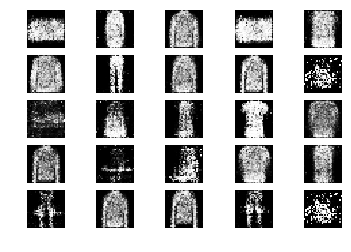

6201 [D loss: 0.587748, acc.: 67.19%] [G loss: 0.985082]
6202 [D loss: 0.638680, acc.: 62.50%] [G loss: 1.037200]
6203 [D loss: 0.657752, acc.: 57.81%] [G loss: 0.965310]
6204 [D loss: 0.631161, acc.: 60.94%] [G loss: 0.976658]
6205 [D loss: 0.591256, acc.: 65.62%] [G loss: 1.069621]
6206 [D loss: 0.593862, acc.: 67.19%] [G loss: 1.012758]
6207 [D loss: 0.654791, acc.: 67.19%] [G loss: 0.974523]
6208 [D loss: 0.649806, acc.: 68.75%] [G loss: 0.980073]
6209 [D loss: 0.612820, acc.: 67.19%] [G loss: 1.116294]
6210 [D loss: 0.584454, acc.: 71.88%] [G loss: 0.979840]
6211 [D loss: 0.724937, acc.: 51.56%] [G loss: 0.982659]
6212 [D loss: 0.682488, acc.: 56.25%] [G loss: 0.999019]
6213 [D loss: 0.617404, acc.: 64.06%] [G loss: 0.925686]
6214 [D loss: 0.671803, acc.: 54.69%] [G loss: 0.988216]
6215 [D loss: 0.598974, acc.: 70.31%] [G loss: 0.923378]
6216 [D loss: 0.641951, acc.: 51.56%] [G loss: 0.925924]
6217 [D loss: 0.612917, acc.: 65.62%] [G loss: 0.949362]
6218 [D loss: 0.670596, acc.: 5

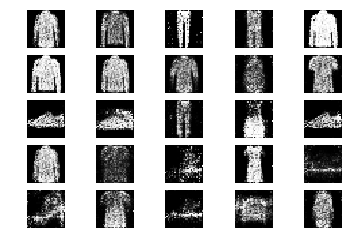

6401 [D loss: 0.606884, acc.: 64.06%] [G loss: 0.910101]
6402 [D loss: 0.556351, acc.: 70.31%] [G loss: 0.993029]
6403 [D loss: 0.673927, acc.: 53.12%] [G loss: 1.030640]
6404 [D loss: 0.643244, acc.: 62.50%] [G loss: 0.979147]
6405 [D loss: 0.672363, acc.: 57.81%] [G loss: 1.015722]
6406 [D loss: 0.686102, acc.: 62.50%] [G loss: 1.083148]
6407 [D loss: 0.644190, acc.: 57.81%] [G loss: 1.044104]
6408 [D loss: 0.599263, acc.: 64.06%] [G loss: 0.971026]
6409 [D loss: 0.645054, acc.: 64.06%] [G loss: 0.872458]
6410 [D loss: 0.583991, acc.: 68.75%] [G loss: 0.965005]
6411 [D loss: 0.581029, acc.: 68.75%] [G loss: 0.902529]
6412 [D loss: 0.606751, acc.: 64.06%] [G loss: 0.887615]
6413 [D loss: 0.628112, acc.: 57.81%] [G loss: 1.014691]
6414 [D loss: 0.620477, acc.: 54.69%] [G loss: 1.062382]
6415 [D loss: 0.603211, acc.: 60.94%] [G loss: 1.039400]
6416 [D loss: 0.582758, acc.: 64.06%] [G loss: 1.066693]
6417 [D loss: 0.581298, acc.: 70.31%] [G loss: 1.035290]
6418 [D loss: 0.652314, acc.: 5

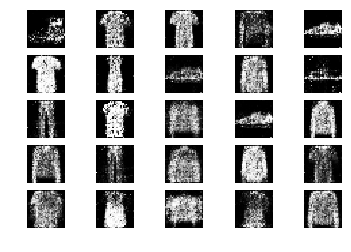

6601 [D loss: 0.613519, acc.: 70.31%] [G loss: 0.964555]
6602 [D loss: 0.556389, acc.: 64.06%] [G loss: 0.977666]
6603 [D loss: 0.580517, acc.: 75.00%] [G loss: 1.024263]
6604 [D loss: 0.589922, acc.: 64.06%] [G loss: 0.949828]
6605 [D loss: 0.637548, acc.: 59.38%] [G loss: 1.115810]
6606 [D loss: 0.610068, acc.: 71.88%] [G loss: 0.929708]
6607 [D loss: 0.682111, acc.: 57.81%] [G loss: 1.020543]
6608 [D loss: 0.669571, acc.: 54.69%] [G loss: 1.030965]
6609 [D loss: 0.630398, acc.: 59.38%] [G loss: 0.952324]
6610 [D loss: 0.669383, acc.: 65.62%] [G loss: 1.031258]
6611 [D loss: 0.590307, acc.: 71.88%] [G loss: 1.114495]
6612 [D loss: 0.669415, acc.: 57.81%] [G loss: 1.184516]
6613 [D loss: 0.660038, acc.: 65.62%] [G loss: 1.088684]
6614 [D loss: 0.592673, acc.: 67.19%] [G loss: 0.941434]
6615 [D loss: 0.656067, acc.: 65.62%] [G loss: 0.995484]
6616 [D loss: 0.607788, acc.: 62.50%] [G loss: 0.948214]
6617 [D loss: 0.561930, acc.: 71.88%] [G loss: 1.085488]
6618 [D loss: 0.654300, acc.: 5

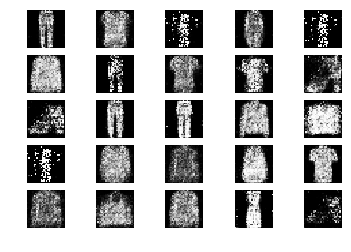

6801 [D loss: 0.569312, acc.: 73.44%] [G loss: 1.055607]
6802 [D loss: 0.703285, acc.: 60.94%] [G loss: 0.907583]
6803 [D loss: 0.633577, acc.: 67.19%] [G loss: 0.887382]
6804 [D loss: 0.621454, acc.: 67.19%] [G loss: 0.930081]
6805 [D loss: 0.582733, acc.: 68.75%] [G loss: 0.996120]
6806 [D loss: 0.547356, acc.: 68.75%] [G loss: 1.042531]
6807 [D loss: 0.605423, acc.: 64.06%] [G loss: 1.033376]
6808 [D loss: 0.609667, acc.: 54.69%] [G loss: 0.947687]
6809 [D loss: 0.664481, acc.: 51.56%] [G loss: 1.044281]
6810 [D loss: 0.522842, acc.: 71.88%] [G loss: 1.141113]
6811 [D loss: 0.633287, acc.: 51.56%] [G loss: 1.090225]
6812 [D loss: 0.662970, acc.: 60.94%] [G loss: 0.994781]
6813 [D loss: 0.545369, acc.: 79.69%] [G loss: 1.022993]
6814 [D loss: 0.679130, acc.: 60.94%] [G loss: 0.947789]
6815 [D loss: 0.597425, acc.: 67.19%] [G loss: 0.951477]
6816 [D loss: 0.585980, acc.: 65.62%] [G loss: 1.002501]
6817 [D loss: 0.552242, acc.: 67.19%] [G loss: 1.118190]
6818 [D loss: 0.636167, acc.: 5

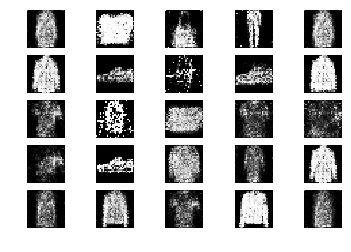

7001 [D loss: 0.599343, acc.: 71.88%] [G loss: 1.182433]
7002 [D loss: 0.527772, acc.: 78.12%] [G loss: 1.126488]
7003 [D loss: 0.668960, acc.: 53.12%] [G loss: 1.075912]
7004 [D loss: 0.544177, acc.: 71.88%] [G loss: 1.173775]
7005 [D loss: 0.704021, acc.: 51.56%] [G loss: 1.056351]
7006 [D loss: 0.642239, acc.: 62.50%] [G loss: 1.031610]
7007 [D loss: 0.615659, acc.: 65.62%] [G loss: 0.984557]
7008 [D loss: 0.695050, acc.: 53.12%] [G loss: 1.116195]
7009 [D loss: 0.614781, acc.: 64.06%] [G loss: 0.991861]
7010 [D loss: 0.584399, acc.: 60.94%] [G loss: 0.968167]
7011 [D loss: 0.647350, acc.: 64.06%] [G loss: 0.938078]
7012 [D loss: 0.620835, acc.: 67.19%] [G loss: 1.013558]
7013 [D loss: 0.587884, acc.: 73.44%] [G loss: 1.004250]
7014 [D loss: 0.633896, acc.: 59.38%] [G loss: 1.025532]
7015 [D loss: 0.739412, acc.: 42.19%] [G loss: 0.990253]
7016 [D loss: 0.684848, acc.: 62.50%] [G loss: 1.014979]
7017 [D loss: 0.672172, acc.: 59.38%] [G loss: 0.960115]
7018 [D loss: 0.637432, acc.: 6

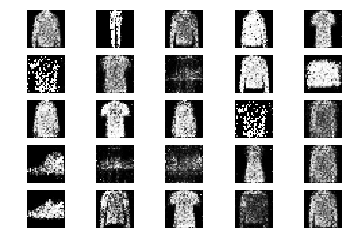

7201 [D loss: 0.610981, acc.: 71.88%] [G loss: 1.026470]
7202 [D loss: 0.618040, acc.: 62.50%] [G loss: 1.002316]
7203 [D loss: 0.621301, acc.: 67.19%] [G loss: 1.032616]
7204 [D loss: 0.668980, acc.: 54.69%] [G loss: 1.142013]
7205 [D loss: 0.666275, acc.: 56.25%] [G loss: 1.094539]
7206 [D loss: 0.732120, acc.: 48.44%] [G loss: 1.050536]
7207 [D loss: 0.687591, acc.: 53.12%] [G loss: 1.022578]
7208 [D loss: 0.628156, acc.: 67.19%] [G loss: 1.102569]
7209 [D loss: 0.655445, acc.: 59.38%] [G loss: 1.037757]
7210 [D loss: 0.634988, acc.: 65.62%] [G loss: 0.972988]
7211 [D loss: 0.670225, acc.: 64.06%] [G loss: 0.911135]
7212 [D loss: 0.639006, acc.: 56.25%] [G loss: 1.036225]
7213 [D loss: 0.612128, acc.: 64.06%] [G loss: 0.979560]
7214 [D loss: 0.581238, acc.: 65.62%] [G loss: 1.010761]
7215 [D loss: 0.663051, acc.: 64.06%] [G loss: 0.981071]
7216 [D loss: 0.601306, acc.: 70.31%] [G loss: 0.942131]
7217 [D loss: 0.608189, acc.: 68.75%] [G loss: 0.996574]
7218 [D loss: 0.623405, acc.: 6

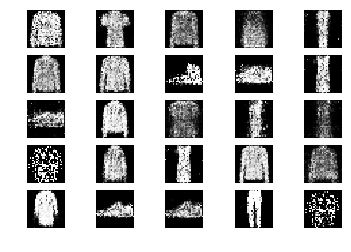

7401 [D loss: 0.619452, acc.: 65.62%] [G loss: 0.967435]
7402 [D loss: 0.635748, acc.: 64.06%] [G loss: 0.956663]
7403 [D loss: 0.601282, acc.: 75.00%] [G loss: 0.955140]
7404 [D loss: 0.529592, acc.: 76.56%] [G loss: 0.968700]
7405 [D loss: 0.566403, acc.: 64.06%] [G loss: 0.893521]
7406 [D loss: 0.614462, acc.: 65.62%] [G loss: 0.999003]
7407 [D loss: 0.587730, acc.: 68.75%] [G loss: 0.947804]
7408 [D loss: 0.515504, acc.: 73.44%] [G loss: 1.000804]
7409 [D loss: 0.634495, acc.: 65.62%] [G loss: 0.996493]
7410 [D loss: 0.647000, acc.: 65.62%] [G loss: 0.894316]
7411 [D loss: 0.665269, acc.: 54.69%] [G loss: 1.114284]
7412 [D loss: 0.655452, acc.: 57.81%] [G loss: 0.914150]
7413 [D loss: 0.708303, acc.: 51.56%] [G loss: 0.965179]
7414 [D loss: 0.694762, acc.: 51.56%] [G loss: 0.992346]
7415 [D loss: 0.653490, acc.: 65.62%] [G loss: 1.085926]
7416 [D loss: 0.617002, acc.: 65.62%] [G loss: 1.117782]
7417 [D loss: 0.629539, acc.: 60.94%] [G loss: 1.093668]
7418 [D loss: 0.694426, acc.: 5

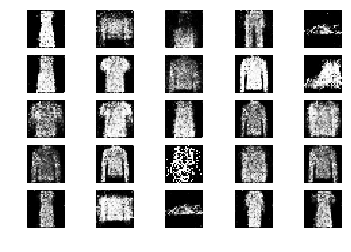

7601 [D loss: 0.586197, acc.: 62.50%] [G loss: 1.043479]
7602 [D loss: 0.625727, acc.: 67.19%] [G loss: 1.010570]
7603 [D loss: 0.709087, acc.: 64.06%] [G loss: 1.047211]
7604 [D loss: 0.624859, acc.: 68.75%] [G loss: 1.071012]
7605 [D loss: 0.672665, acc.: 62.50%] [G loss: 1.066375]
7606 [D loss: 0.702012, acc.: 62.50%] [G loss: 0.979950]
7607 [D loss: 0.562831, acc.: 70.31%] [G loss: 0.949913]
7608 [D loss: 0.646033, acc.: 62.50%] [G loss: 0.901645]
7609 [D loss: 0.650890, acc.: 62.50%] [G loss: 0.926545]
7610 [D loss: 0.710808, acc.: 60.94%] [G loss: 1.021156]
7611 [D loss: 0.660792, acc.: 62.50%] [G loss: 1.216418]
7612 [D loss: 0.598729, acc.: 67.19%] [G loss: 1.002596]
7613 [D loss: 0.643990, acc.: 64.06%] [G loss: 1.185230]
7614 [D loss: 0.610892, acc.: 68.75%] [G loss: 1.031622]
7615 [D loss: 0.656516, acc.: 64.06%] [G loss: 0.904657]
7616 [D loss: 0.635520, acc.: 67.19%] [G loss: 0.864125]
7617 [D loss: 0.595800, acc.: 71.88%] [G loss: 0.939129]
7618 [D loss: 0.754280, acc.: 4

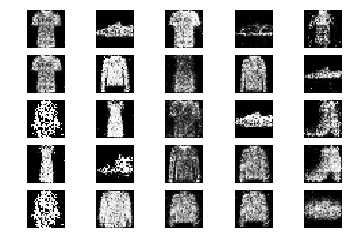

7801 [D loss: 0.621790, acc.: 70.31%] [G loss: 0.993585]
7802 [D loss: 0.636543, acc.: 56.25%] [G loss: 0.927768]
7803 [D loss: 0.609079, acc.: 65.62%] [G loss: 0.860448]
7804 [D loss: 0.583166, acc.: 76.56%] [G loss: 0.901212]
7805 [D loss: 0.589898, acc.: 75.00%] [G loss: 0.893900]
7806 [D loss: 0.630584, acc.: 65.62%] [G loss: 0.912353]
7807 [D loss: 0.597124, acc.: 71.88%] [G loss: 1.044226]
7808 [D loss: 0.715018, acc.: 60.94%] [G loss: 0.947465]
7809 [D loss: 0.657165, acc.: 68.75%] [G loss: 1.043251]
7810 [D loss: 0.541659, acc.: 75.00%] [G loss: 0.990736]
7811 [D loss: 0.664538, acc.: 54.69%] [G loss: 0.975335]
7812 [D loss: 0.680494, acc.: 46.88%] [G loss: 0.993399]
7813 [D loss: 0.639550, acc.: 67.19%] [G loss: 0.908856]
7814 [D loss: 0.625572, acc.: 65.62%] [G loss: 0.949492]
7815 [D loss: 0.634036, acc.: 54.69%] [G loss: 0.929113]
7816 [D loss: 0.619699, acc.: 57.81%] [G loss: 0.933094]
7817 [D loss: 0.639333, acc.: 68.75%] [G loss: 0.892639]
7818 [D loss: 0.589468, acc.: 5

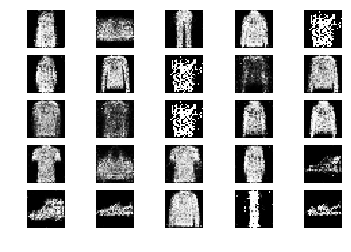

8001 [D loss: 0.679146, acc.: 56.25%] [G loss: 0.947377]
8002 [D loss: 0.666436, acc.: 62.50%] [G loss: 1.027662]
8003 [D loss: 0.676521, acc.: 57.81%] [G loss: 1.037632]
8004 [D loss: 0.701100, acc.: 57.81%] [G loss: 1.051956]
8005 [D loss: 0.640499, acc.: 59.38%] [G loss: 0.986650]
8006 [D loss: 0.594355, acc.: 67.19%] [G loss: 1.085996]
8007 [D loss: 0.604459, acc.: 65.62%] [G loss: 1.089592]
8008 [D loss: 0.587459, acc.: 71.88%] [G loss: 1.104972]
8009 [D loss: 0.559615, acc.: 78.12%] [G loss: 1.100074]
8010 [D loss: 0.622699, acc.: 67.19%] [G loss: 1.109082]
8011 [D loss: 0.590408, acc.: 76.56%] [G loss: 0.985909]
8012 [D loss: 0.597227, acc.: 68.75%] [G loss: 1.037146]
8013 [D loss: 0.667119, acc.: 57.81%] [G loss: 1.002036]
8014 [D loss: 0.603347, acc.: 67.19%] [G loss: 1.115472]
8015 [D loss: 0.620916, acc.: 68.75%] [G loss: 1.000553]
8016 [D loss: 0.674618, acc.: 56.25%] [G loss: 0.907339]
8017 [D loss: 0.635585, acc.: 62.50%] [G loss: 0.883898]
8018 [D loss: 0.618138, acc.: 6

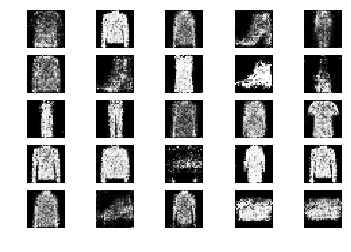

8201 [D loss: 0.675188, acc.: 59.38%] [G loss: 0.899964]
8202 [D loss: 0.706345, acc.: 45.31%] [G loss: 0.967028]
8203 [D loss: 0.698037, acc.: 43.75%] [G loss: 1.023995]
8204 [D loss: 0.634160, acc.: 64.06%] [G loss: 1.044366]
8205 [D loss: 0.635152, acc.: 67.19%] [G loss: 1.019098]
8206 [D loss: 0.626706, acc.: 59.38%] [G loss: 0.933437]
8207 [D loss: 0.616836, acc.: 67.19%] [G loss: 0.996138]
8208 [D loss: 0.603187, acc.: 67.19%] [G loss: 1.025616]
8209 [D loss: 0.663256, acc.: 59.38%] [G loss: 0.956684]
8210 [D loss: 0.678261, acc.: 59.38%] [G loss: 0.957114]
8211 [D loss: 0.663873, acc.: 57.81%] [G loss: 0.919948]
8212 [D loss: 0.619229, acc.: 59.38%] [G loss: 0.880280]
8213 [D loss: 0.622230, acc.: 57.81%] [G loss: 0.944638]
8214 [D loss: 0.793440, acc.: 54.69%] [G loss: 0.924508]
8215 [D loss: 0.694966, acc.: 57.81%] [G loss: 1.031069]
8216 [D loss: 0.637089, acc.: 59.38%] [G loss: 1.041054]
8217 [D loss: 0.683110, acc.: 56.25%] [G loss: 0.911511]
8218 [D loss: 0.650946, acc.: 6

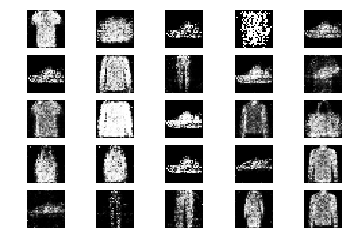

8401 [D loss: 0.581096, acc.: 71.88%] [G loss: 0.995329]
8402 [D loss: 0.590148, acc.: 62.50%] [G loss: 0.912693]
8403 [D loss: 0.642176, acc.: 57.81%] [G loss: 0.914348]
8404 [D loss: 0.612596, acc.: 62.50%] [G loss: 1.030610]
8405 [D loss: 0.597307, acc.: 65.62%] [G loss: 0.984650]
8406 [D loss: 0.606113, acc.: 59.38%] [G loss: 1.047067]
8407 [D loss: 0.640967, acc.: 57.81%] [G loss: 0.920247]
8408 [D loss: 0.674071, acc.: 56.25%] [G loss: 1.084102]
8409 [D loss: 0.685696, acc.: 51.56%] [G loss: 0.978733]
8410 [D loss: 0.678504, acc.: 57.81%] [G loss: 1.041146]
8411 [D loss: 0.582317, acc.: 67.19%] [G loss: 1.019098]
8412 [D loss: 0.737086, acc.: 51.56%] [G loss: 1.027815]
8413 [D loss: 0.640220, acc.: 62.50%] [G loss: 0.916505]
8414 [D loss: 0.572963, acc.: 75.00%] [G loss: 1.027838]
8415 [D loss: 0.609177, acc.: 71.88%] [G loss: 0.936599]
8416 [D loss: 0.643307, acc.: 62.50%] [G loss: 0.903861]
8417 [D loss: 0.634177, acc.: 65.62%] [G loss: 0.900066]
8418 [D loss: 0.729867, acc.: 4

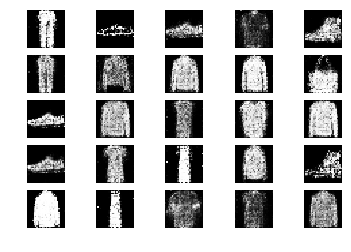

8601 [D loss: 0.612382, acc.: 65.62%] [G loss: 0.948077]
8602 [D loss: 0.605859, acc.: 67.19%] [G loss: 0.896266]
8603 [D loss: 0.563646, acc.: 75.00%] [G loss: 0.967973]
8604 [D loss: 0.570363, acc.: 73.44%] [G loss: 0.856344]
8605 [D loss: 0.688664, acc.: 56.25%] [G loss: 0.858216]
8606 [D loss: 0.666453, acc.: 62.50%] [G loss: 0.892013]
8607 [D loss: 0.639574, acc.: 64.06%] [G loss: 0.999628]
8608 [D loss: 0.641047, acc.: 54.69%] [G loss: 0.866143]
8609 [D loss: 0.577479, acc.: 75.00%] [G loss: 0.877828]
8610 [D loss: 0.649626, acc.: 64.06%] [G loss: 0.923812]
8611 [D loss: 0.638633, acc.: 60.94%] [G loss: 0.902945]
8612 [D loss: 0.645454, acc.: 65.62%] [G loss: 0.893718]
8613 [D loss: 0.573731, acc.: 71.88%] [G loss: 1.005164]
8614 [D loss: 0.762099, acc.: 54.69%] [G loss: 0.993543]
8615 [D loss: 0.563844, acc.: 75.00%] [G loss: 0.979724]
8616 [D loss: 0.678431, acc.: 54.69%] [G loss: 0.907399]
8617 [D loss: 0.616249, acc.: 70.31%] [G loss: 0.934328]
8618 [D loss: 0.646352, acc.: 5

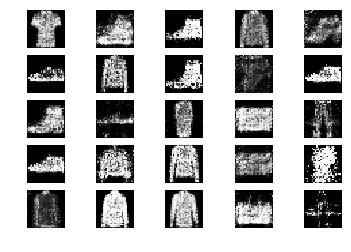

8801 [D loss: 0.642668, acc.: 62.50%] [G loss: 0.947293]
8802 [D loss: 0.643137, acc.: 59.38%] [G loss: 0.870272]
8803 [D loss: 0.650279, acc.: 60.94%] [G loss: 0.855834]
8804 [D loss: 0.620207, acc.: 62.50%] [G loss: 0.838892]
8805 [D loss: 0.642590, acc.: 67.19%] [G loss: 0.861503]
8806 [D loss: 0.654203, acc.: 65.62%] [G loss: 1.023350]
8807 [D loss: 0.632061, acc.: 62.50%] [G loss: 1.009647]
8808 [D loss: 0.691114, acc.: 60.94%] [G loss: 1.093657]
8809 [D loss: 0.732731, acc.: 54.69%] [G loss: 0.940672]
8810 [D loss: 0.639186, acc.: 64.06%] [G loss: 0.909556]
8811 [D loss: 0.592343, acc.: 73.44%] [G loss: 0.857231]
8812 [D loss: 0.627996, acc.: 57.81%] [G loss: 0.847053]
8813 [D loss: 0.589274, acc.: 67.19%] [G loss: 0.938817]
8814 [D loss: 0.656578, acc.: 59.38%] [G loss: 1.090959]
8815 [D loss: 0.707448, acc.: 65.62%] [G loss: 1.061076]
8816 [D loss: 0.693831, acc.: 53.12%] [G loss: 1.046267]
8817 [D loss: 0.720074, acc.: 56.25%] [G loss: 1.093244]
8818 [D loss: 0.590320, acc.: 6

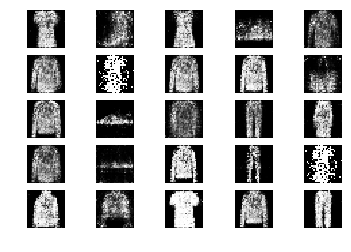

9001 [D loss: 0.599866, acc.: 64.06%] [G loss: 0.974690]
9002 [D loss: 0.597477, acc.: 68.75%] [G loss: 0.957225]
9003 [D loss: 0.617092, acc.: 71.88%] [G loss: 0.831648]
9004 [D loss: 0.587941, acc.: 64.06%] [G loss: 0.896061]
9005 [D loss: 0.628177, acc.: 68.75%] [G loss: 0.907623]
9006 [D loss: 0.595179, acc.: 71.88%] [G loss: 0.892634]
9007 [D loss: 0.683822, acc.: 62.50%] [G loss: 0.808422]
9008 [D loss: 0.641564, acc.: 62.50%] [G loss: 0.967011]
9009 [D loss: 0.607073, acc.: 65.62%] [G loss: 1.046947]
9010 [D loss: 0.706452, acc.: 57.81%] [G loss: 1.108068]
9011 [D loss: 0.719014, acc.: 43.75%] [G loss: 1.080845]
9012 [D loss: 0.719316, acc.: 51.56%] [G loss: 1.022536]
9013 [D loss: 0.800668, acc.: 37.50%] [G loss: 0.963224]
9014 [D loss: 0.599069, acc.: 75.00%] [G loss: 1.007724]
9015 [D loss: 0.658260, acc.: 51.56%] [G loss: 1.018910]
9016 [D loss: 0.651306, acc.: 56.25%] [G loss: 0.953657]
9017 [D loss: 0.592107, acc.: 71.88%] [G loss: 1.013772]
9018 [D loss: 0.620534, acc.: 6

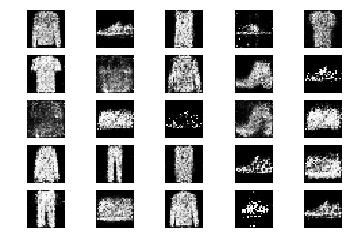

9201 [D loss: 0.691412, acc.: 62.50%] [G loss: 0.883167]
9202 [D loss: 0.612156, acc.: 68.75%] [G loss: 1.048801]
9203 [D loss: 0.619508, acc.: 57.81%] [G loss: 0.999541]
9204 [D loss: 0.645423, acc.: 65.62%] [G loss: 1.023714]
9205 [D loss: 0.618859, acc.: 65.62%] [G loss: 0.991539]
9206 [D loss: 0.667357, acc.: 64.06%] [G loss: 0.935185]
9207 [D loss: 0.694374, acc.: 51.56%] [G loss: 1.019069]
9208 [D loss: 0.722826, acc.: 57.81%] [G loss: 1.015477]
9209 [D loss: 0.617193, acc.: 65.62%] [G loss: 0.991103]
9210 [D loss: 0.558255, acc.: 79.69%] [G loss: 0.878556]
9211 [D loss: 0.620665, acc.: 57.81%] [G loss: 0.939708]
9212 [D loss: 0.660976, acc.: 67.19%] [G loss: 1.037114]
9213 [D loss: 0.650672, acc.: 65.62%] [G loss: 0.913413]
9214 [D loss: 0.615628, acc.: 68.75%] [G loss: 1.016434]
9215 [D loss: 0.628746, acc.: 62.50%] [G loss: 0.945385]
9216 [D loss: 0.658608, acc.: 62.50%] [G loss: 1.027997]
9217 [D loss: 0.637368, acc.: 60.94%] [G loss: 0.932272]
9218 [D loss: 0.607091, acc.: 6

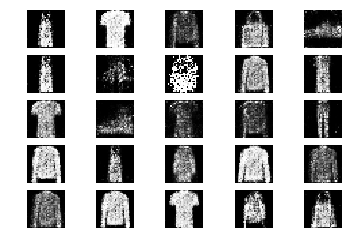

9401 [D loss: 0.698776, acc.: 56.25%] [G loss: 1.021064]
9402 [D loss: 0.714167, acc.: 45.31%] [G loss: 0.915308]
9403 [D loss: 0.640548, acc.: 59.38%] [G loss: 0.983326]
9404 [D loss: 0.701280, acc.: 64.06%] [G loss: 0.946898]
9405 [D loss: 0.626303, acc.: 59.38%] [G loss: 0.908255]
9406 [D loss: 0.763231, acc.: 57.81%] [G loss: 0.893309]
9407 [D loss: 0.641099, acc.: 68.75%] [G loss: 0.846696]
9408 [D loss: 0.662056, acc.: 57.81%] [G loss: 0.897409]
9409 [D loss: 0.644967, acc.: 64.06%] [G loss: 1.029952]
9410 [D loss: 0.639529, acc.: 60.94%] [G loss: 1.017492]
9411 [D loss: 0.623542, acc.: 68.75%] [G loss: 1.014162]
9412 [D loss: 0.651947, acc.: 64.06%] [G loss: 1.055839]
9413 [D loss: 0.635035, acc.: 67.19%] [G loss: 1.048030]
9414 [D loss: 0.590474, acc.: 71.88%] [G loss: 0.977026]
9415 [D loss: 0.600905, acc.: 64.06%] [G loss: 0.953198]
9416 [D loss: 0.641444, acc.: 54.69%] [G loss: 0.954339]
9417 [D loss: 0.673128, acc.: 53.12%] [G loss: 0.952891]
9418 [D loss: 0.608297, acc.: 6

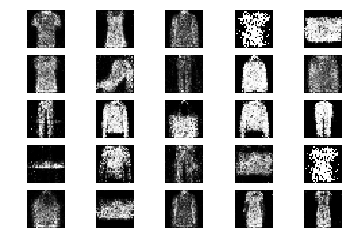

9601 [D loss: 0.693884, acc.: 57.81%] [G loss: 0.840847]
9602 [D loss: 0.652842, acc.: 64.06%] [G loss: 0.888528]
9603 [D loss: 0.658215, acc.: 62.50%] [G loss: 0.962442]
9604 [D loss: 0.674778, acc.: 64.06%] [G loss: 0.881253]
9605 [D loss: 0.634544, acc.: 65.62%] [G loss: 0.992871]
9606 [D loss: 0.599012, acc.: 67.19%] [G loss: 0.955365]
9607 [D loss: 0.710533, acc.: 51.56%] [G loss: 0.891620]
9608 [D loss: 0.621439, acc.: 62.50%] [G loss: 0.909624]
9609 [D loss: 0.636101, acc.: 64.06%] [G loss: 0.968914]
9610 [D loss: 0.706176, acc.: 51.56%] [G loss: 0.909286]
9611 [D loss: 0.638196, acc.: 60.94%] [G loss: 0.936933]
9612 [D loss: 0.704940, acc.: 60.94%] [G loss: 0.940034]
9613 [D loss: 0.627377, acc.: 60.94%] [G loss: 0.913110]
9614 [D loss: 0.726370, acc.: 57.81%] [G loss: 0.931330]
9615 [D loss: 0.610145, acc.: 64.06%] [G loss: 0.963123]
9616 [D loss: 0.743111, acc.: 48.44%] [G loss: 0.986263]
9617 [D loss: 0.671371, acc.: 57.81%] [G loss: 0.985373]
9618 [D loss: 0.663597, acc.: 6

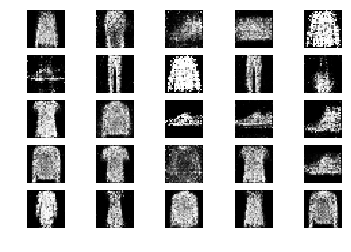

9801 [D loss: 0.593338, acc.: 64.06%] [G loss: 1.010142]
9802 [D loss: 0.652810, acc.: 65.62%] [G loss: 0.998461]
9803 [D loss: 0.689907, acc.: 56.25%] [G loss: 0.995093]
9804 [D loss: 0.691123, acc.: 57.81%] [G loss: 0.940570]
9805 [D loss: 0.702135, acc.: 57.81%] [G loss: 0.948169]
9806 [D loss: 0.590581, acc.: 68.75%] [G loss: 1.006467]
9807 [D loss: 0.567508, acc.: 73.44%] [G loss: 0.953819]
9808 [D loss: 0.608620, acc.: 71.88%] [G loss: 1.045335]
9809 [D loss: 0.629972, acc.: 62.50%] [G loss: 1.090015]
9810 [D loss: 0.678873, acc.: 64.06%] [G loss: 0.879526]
9811 [D loss: 0.642236, acc.: 59.38%] [G loss: 0.949890]
9812 [D loss: 0.706254, acc.: 54.69%] [G loss: 0.895934]
9813 [D loss: 0.649955, acc.: 62.50%] [G loss: 0.915359]
9814 [D loss: 0.613814, acc.: 62.50%] [G loss: 0.889394]
9815 [D loss: 0.596472, acc.: 70.31%] [G loss: 0.884137]
9816 [D loss: 0.645897, acc.: 65.62%] [G loss: 1.004636]
9817 [D loss: 0.646028, acc.: 53.12%] [G loss: 0.927588]
9818 [D loss: 0.637646, acc.: 6

In [0]:
gan = GAN()
gan.train(epochs=10000, batch_size=32, sample_interval=200)

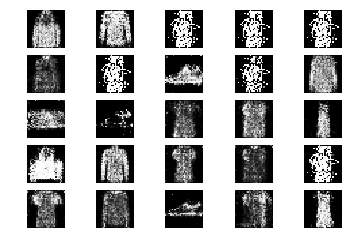

In [0]:
gan.sample_images(100)

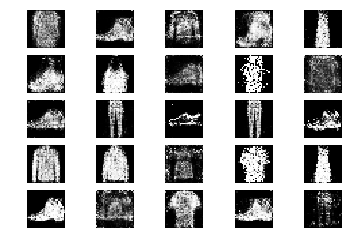

In [0]:
gan.sample_images(1000)

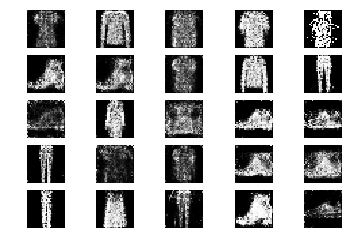

In [0]:
gan.sample_images(10000)

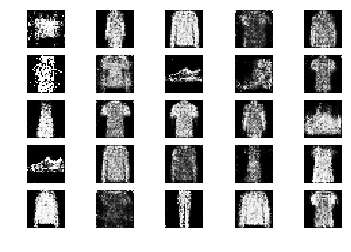

In [0]:
gan.sample_images(100000)

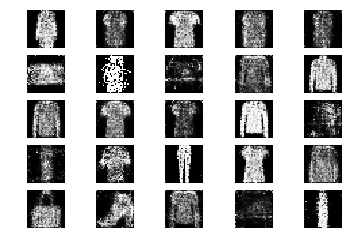

In [0]:
gan.sample_images(100000000)